# QSVM on MNIST

In [16]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split

from utils import * # It contains functions for threat the data (I/O, encoding/decoding) and metrics for evaluations 

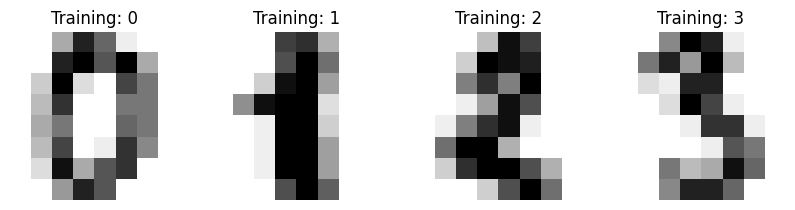

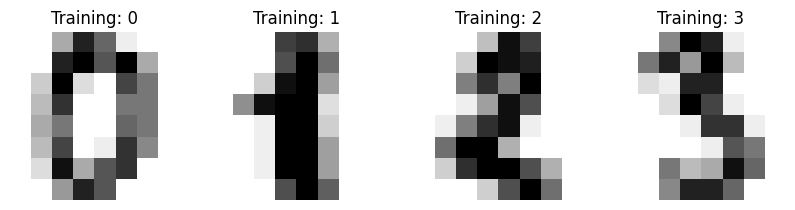

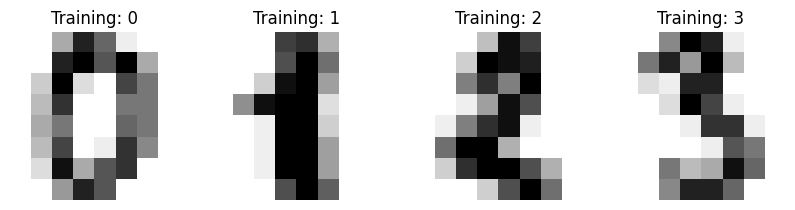

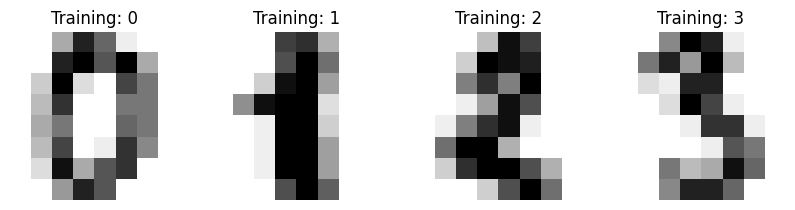

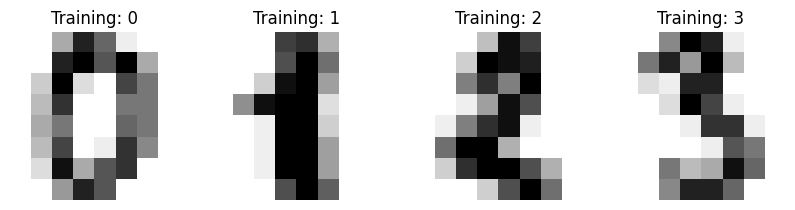

In [9]:
%matplotlib inline
digits = datasets.load_digits()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Training: {label}")

plt.show()

In [8]:
print(len(digits.images))

1797


In [11]:
X = digits.data       # features
y = digits.target     # labels

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [31]:
import os

def write_samples(X, Y, path): 
    import os
    os.makedirs(os.path.dirname(path), exist_ok=True)

    with open(path, "w") as f: 
        f.write("id label data\n") 
        for i in range(X.shape[0]):
            features = " ".join(str(val) for val in X[i])   # no brackets, no commas
            f.write(f"{i} {Y[i]} {features}\n")

In [37]:
from sklearn import preprocessing

# 10-fold Monte Carlo (or split-and-shuffle) cross-validation
fold=10

id_dataset = "mnist"
for i in range(0,fold):
    X_train_cal, X_val_cal, Y_train_cal, Y_val_cal = train_test_split(X_train,y_train, test_size=0.94, random_state=i)
    
    # Pre-processing 
    X_train_cal = preprocessing.scale(X_train_cal)
    X_val_cal = preprocessing.scale(X_val_cal)
        
    # Write the data
    write_samples(X_train_cal, Y_train_cal,'input_datasets/calibration/'+id_dataset+'/'+id_dataset+'calibtrain'+str(i))
    write_samples(X_val_cal, Y_val_cal,'input_datasets/calibration/'+id_dataset+'/'+id_dataset+'calibval'+str(i))
    
print('Each training set includes '+str(X_train_cal.shape[0])+ ' samples')
print('Each validation set includes '+str(X_val_cal.shape[0])+ ' samples')

Each training set includes 75 samples
Each validation set includes 1182 samples


In [38]:
from quantum_SVM import *

# Hyperparameters 
B=[2,3,5,10]
K=[2,3]
xi=[0,1,5]
gamma=[-1,0.125,0.25,0.5,1,2,4,8]
n_experiments=len(B)*len(K)*len(xi)*len(gamma)

hyperparameters=np.zeros([n_experiments,4], dtype=float)

path_data_key='input_datasets/calibration/'+id_dataset+'/'
data_key = id_dataset+'calibtrain'
path_out='outputs/calibration/'+id_dataset+'/'

trainacc=np.zeros([fold], dtype=float)
trainauroc=np.zeros([fold], dtype=float)
trainauprc=np.zeros([fold], dtype=float)
    
testacc=np.zeros([fold], dtype=float)
testauroc=np.zeros([fold], dtype=float)
testauprc=np.zeros([fold], dtype=float)

trainacc_all=np.zeros([n_experiments], dtype=float)
trainauroc_all=np.zeros([n_experiments], dtype=float)
trainauprc_all=np.zeros([n_experiments], dtype=float)
    
testacc_all=np.zeros([n_experiments], dtype=float)
testauroc_all=np.zeros([n_experiments], dtype=float)
testauprc_all=np.zeros([n_experiments], dtype=float)


f = open(path_out+'calibration_results.txt',"w") 
f.write("B\t K\t xi\t   gamma\t trainacc\t trainauroc\t trainauprc\t testacc\t testauroc\t testauprc\n") 
  
count=0 
for x in range(0,len(B)):
    for y in range(0,len(K)):
        for z in range(0,len(xi)):
            for i in range(0,len(gamma)):
                for j in range(0,fold):
                    path=gen_svm_qubos(B[x],K[y],xi[z],gamma[i],path_data_key,data_key+str(j),path_out)
                    pathsub=dwave_run(path_data_key,path)
                    [trainacc[j],trainauroc[j],trainauprc[j],testacc[j],testauroc[j],testauprc[j]]=eval_run_rocpr_curves(path_data_key,pathsub,'noplotsave')
                    
                hyperparameters[count,0]=B[x]
                hyperparameters[count,1]=K[y]
                hyperparameters[count,2]=xi[z]
                hyperparameters[count,3]=gamma[i]
            
                trainacc_all[count]=np.average(trainacc)
                trainauroc_all[count]=np.average(trainauroc)
                trainauprc_all[count]=np.average(trainauprc)
    
                testacc_all[count]=np.average(testacc)
                testauroc_all[count]=np.average(testauroc)
                testauprc_all[count]=np.average(testauprc)
                
                np.save(path_out+'hyperparameters', hyperparameters)
                np.save(path_out+'trainacc_all', trainacc_all)
                np.save(path_out+'trainauroc_all', trainauroc_all)
                np.save(path_out+'trainauprc_all', trainauprc_all)
                np.save(path_out+'testacc_all', testacc_all)
                np.save(path_out+'testauroc_all', testauroc_all)
                np.save(path_out+'testauprc_all', testauprc_all)
                
                f.write(f'{B[x]}\t {K[y]}\t {xi[z]}\t {gamma[i]:8.3f}\t {np.average(trainacc):8.4f}\t {np.average(trainauroc):8.4f}\t {np.average(trainauprc):8.4f}\t {np.average(testacc):8.4f}\t {np.average(testauroc):8.4f}\t {np.average(testauprc):8.4f}')
                f.write("\n") 
                count=count+1
                
f.close() 

Creating the QUBO of size (150, 150)
Extracting nodes and couplers
Saving 150 nodes and 11175 couplers for outputs/calibration/mnist/runmnistcalibtrain0_B=2_K=2_xi=0_gamma=-1/
running outputs/calibration/mnist/runmnistcalibtrain0_B=2_K=2_xi=0_gamma=-1/result_couplers=11175/ with 150 nodes and 11175 couplers


TypeError: 'BinaryQuadraticModel' object is not iterable

In [34]:
import os
import numpy as np
from dimod import BinaryQuadraticModel

def dwave_run(path_data_key, path_in):
    """
    Run a QUBO through D-Wave's workflow.
    path_data_key: directory with dataset
    path_in: path where QUBO matrix is stored (numpy .npy file or similar)
    """

    # Load the QUBO matrix (assuming you saved it with np.save)
    Q = np.load(os.path.join(path_in, "qubo.npy"))

    # Create subfolder for results
    pathsub = os.path.join(path_in, "result_couplers=" + str(np.count_nonzero(Q)))
    os.makedirs(pathsub, exist_ok=True)

    # Build the BQM
    bqm = BinaryQuadraticModel.from_qubo(Q)

    # Extract variable ordering correctly
    ordering = np.array(list(bqm.variables))
    if not (ordering == np.arange(len(ordering), dtype=ordering.dtype)).all():
        print(f"WARNING: variables are not correctly ordered! path={path_in} ordering={ordering}")

    print(f"running {pathsub} with {len(bqm.variables)} nodes and {np.count_nonzero(Q)} couplers")

    # --- at this point you would actually submit `bqm` to D-Wave sampler ---
    # Example (using Ocean):
    # from dwave.system import EmbeddingComposite, DWaveSampler
    # sampler = EmbeddingComposite(DWaveSampler())
    # sampleset = sampler.sample(bqm, num_reads=100)
    # sampleset.to_file(os.path.join(pathsub, "samples.json"))

    return pathsub